In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = config["image_epochs"]
LR = 1e-4
IN_SHAPE = config["image_shape"]
MAGNIFICATION = config["magnification"]
N_MAG = config["n_magnification"]
center_disp, center_scale, amp_scale, amp_disp = config["lens_centers_disp"], config["lens_centers_scale"], config["lens_amp_scale"], config["lens_amp_disp"]
resolution = config["resolution"]/(MAGNIFICATION*N_MAG)

In [4]:
BATCH_SIZE = 5
dataset = data.LensingDataset('/home/anirudh/Documents/GSoC/DeepLense_2024/Simulations/data_model_1/',['no_sub'],5000)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

In [5]:
i_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["i_depth"], in_channels=1, latent_channel_count=config["i_latent_channels"]).to(device)

alpha = torch.tensor([[config["alpha"] for _ in range(IN_SHAPE*MAGNIFICATION*N_MAG)] for __ in range(IN_SHAPE*MAGNIFICATION*N_MAG)]).to(device)
phy_loss = models.SersicProfiler(in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, resolution=resolution, device=device, alpha=alpha, BATCH_SIZE=BATCH_SIZE, sersic_args = [20, 1, 0.25])

opt = torch.optim.Adam(params=i_model.parameters(),lr=LR)
i_params = sum(p.numel() for p in i_model.parameters())
print(f"Image network parameters: {i_params}")

Image network parameters: 899843


In [6]:
def give_random_image(dataset, model1, length, i=None, plot=True):
    """
    To display a random image for illustration

    :param dataset: Dataset used
    :param model: Model used
    :param length: Length of dataset used
    :return: original LR image, SR image, original HR image
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i]
    t = LR.clone().detach().view(1,1,IN_SHAPE,IN_SHAPE)
    image = model1(t.float().to(device)).cpu().detach()
    sersic_profile, source_profile = phy_loss.get_sample(image, plot)
    image1 = Image.fromarray(image.numpy()[0][0]*255)
    image2 = Image.fromarray(sersic_profile.cpu().detach().numpy()*255)
    # image3 = Image.fromarray(source_profile.cpu().detach().numpy()[0][0]*255)
    return (Image.fromarray(t.numpy()[0][0]*255), image1, image2)

def show_random_image(image_tuple):
    image0, image1, image2 = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(image0)
    axes[1].imshow(image1)
    axes[2].imshow(image2)
    axes[0].set_title("LR")
    axes[1].set_title("Image")
    axes[2].set_title("Re-lensing profile")

In [7]:
i_model.load_state_dict(torch.load('bicubic.pt'))

<All keys matched successfully>

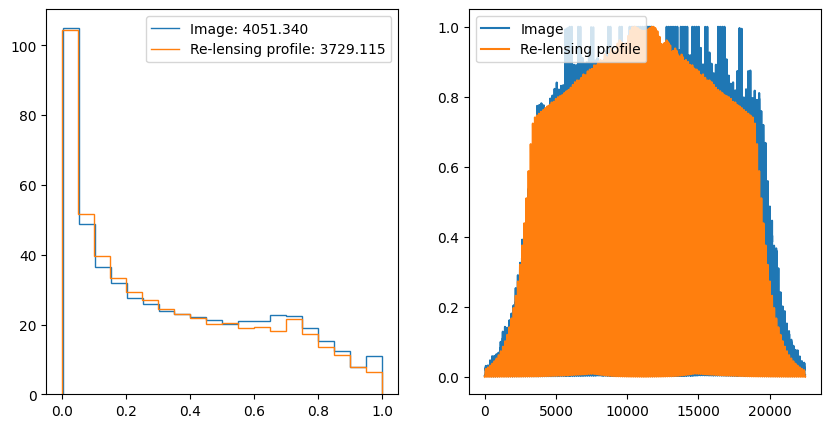

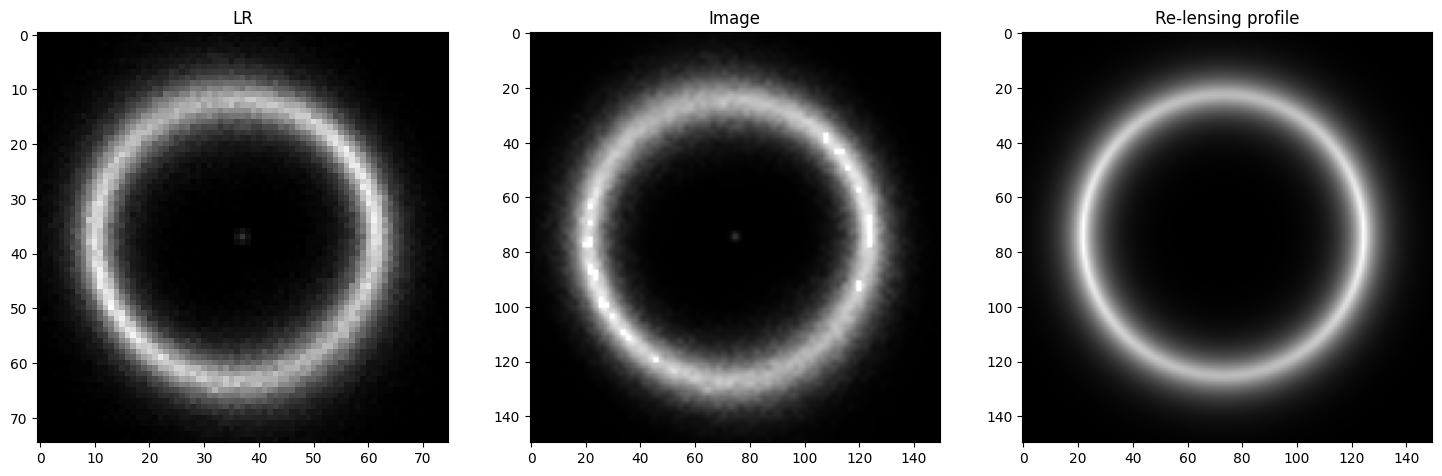

In [8]:
show_random_image(give_random_image(val_dataset, i_model, len(val_dataset)))

In [9]:
best_val_loss = np.inf
best_i_weights = None
best_s_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'relens':[]}
for epoch in range(EPOCHS):
    losses = []
    i_model.train()
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        loss = phy_loss(image, torch.nn.functional.interpolate(input=x, scale_factor=MAGNIFICATION*N_MAG,mode='bicubic'))
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses))
    i_model.eval()
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        image = i_model(x)
        val_loss = phy_loss(image, torch.nn.functional.interpolate(input=x, scale_factor=MAGNIFICATION*N_MAG,mode='bicubic'))
        losses.append(float(val_loss))
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = i_model.state_dict()
    history['val_loss'].append(np.mean(losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses)} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, i_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['relens'].append(sr)

Training epoch 1: 100%|██████████| 800/800 [00:34<00:00, 23.45it/s]


Training at epoch 1/100: 0.000765512811813096 at LR=0.0001


Validation epoch 1: 100%|██████████| 200/200 [00:03<00:00, 59.36it/s]


Validation at epoch 1/100: 0.0010622111780685373 at LR=0.0001


Training epoch 2: 100%|██████████| 800/800 [00:34<00:00, 23.42it/s]


Training at epoch 2/100: 0.0007481600880419137 at LR=0.0001


Validation epoch 2: 100%|██████████| 200/200 [00:03<00:00, 60.81it/s]


Validation at epoch 2/100: 0.0007786098723590839 at LR=0.0001


Training epoch 3: 100%|██████████| 800/800 [00:34<00:00, 23.42it/s]


Training at epoch 3/100: 0.0007178286009730073 at LR=0.0001


Validation epoch 3: 100%|██████████| 200/200 [00:03<00:00, 58.99it/s]


Validation at epoch 3/100: 0.0007433106408279855 at LR=0.0001


Training epoch 4: 100%|██████████| 800/800 [00:34<00:00, 23.32it/s]


Training at epoch 4/100: 0.0006808714674480143 at LR=0.0001


Validation epoch 4: 100%|██████████| 200/200 [00:03<00:00, 60.18it/s]


Validation at epoch 4/100: 0.0006280189055541996 at LR=0.0001


Training epoch 5: 100%|██████████| 800/800 [00:34<00:00, 23.34it/s]


Training at epoch 5/100: 0.0006667325699891081 at LR=0.0001


Validation epoch 5: 100%|██████████| 200/200 [00:03<00:00, 59.54it/s]


Validation at epoch 5/100: 0.0007952307289815508 at LR=0.0001


Training epoch 6: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 6/100: 0.0006654955759222503 at LR=0.0001


Validation epoch 6: 100%|██████████| 200/200 [00:03<00:00, 58.61it/s]


Validation at epoch 6/100: 0.0006237224736833014 at LR=0.0001


Training epoch 7: 100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Training at epoch 7/100: 0.0006570937241485808 at LR=0.0001


Validation epoch 7: 100%|██████████| 200/200 [00:03<00:00, 59.16it/s]


Validation at epoch 7/100: 0.0007295703930140007 at LR=0.0001


Training epoch 8: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 8/100: 0.000629684003033617 at LR=0.0001


Validation epoch 8: 100%|██████████| 200/200 [00:03<00:00, 59.54it/s]


Validation at epoch 8/100: 0.0006078153745329473 at LR=0.0001


Training epoch 9: 100%|██████████| 800/800 [00:34<00:00, 23.16it/s]


Training at epoch 9/100: 0.0006246368582287687 at LR=0.0001


Validation epoch 9: 100%|██████████| 200/200 [00:03<00:00, 59.96it/s]


Validation at epoch 9/100: 0.0007251258664473426 at LR=0.0001


Training epoch 10: 100%|██████████| 800/800 [00:34<00:00, 23.09it/s]


Training at epoch 10/100: 0.0006177475555523415 at LR=0.0001


Validation epoch 10: 100%|██████████| 200/200 [00:03<00:00, 58.83it/s]


Validation at epoch 10/100: 0.000578206985956058 at LR=0.0001


Training epoch 11: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 11/100: 0.0005891938238346484 at LR=0.0001


Validation epoch 11: 100%|██████████| 200/200 [00:03<00:00, 59.72it/s]


Validation at epoch 11/100: 0.0005746831714350264 at LR=0.0001


Training epoch 12: 100%|██████████| 800/800 [00:34<00:00, 23.16it/s]


Training at epoch 12/100: 0.0005802142977336189 at LR=0.0001


Validation epoch 12: 100%|██████████| 200/200 [00:03<00:00, 59.87it/s]


Validation at epoch 12/100: 0.0005598758878477383 at LR=0.0001


Training epoch 13: 100%|██████████| 800/800 [00:34<00:00, 23.15it/s]


Training at epoch 13/100: 0.0005588944049668499 at LR=0.0001


Validation epoch 13: 100%|██████████| 200/200 [00:03<00:00, 59.29it/s]


Validation at epoch 13/100: 0.0006025178074196447 at LR=0.0001


Training epoch 14: 100%|██████████| 800/800 [00:34<00:00, 23.14it/s]


Training at epoch 14/100: 0.0005582275734013819 at LR=0.0001


Validation epoch 14: 100%|██████████| 200/200 [00:03<00:00, 59.33it/s]


Validation at epoch 14/100: 0.0005481416438124142 at LR=0.0001


Training epoch 15: 100%|██████████| 800/800 [00:34<00:00, 23.14it/s]


Training at epoch 15/100: 0.000554213382092712 at LR=0.0001


Validation epoch 15: 100%|██████████| 200/200 [00:03<00:00, 59.16it/s]


Validation at epoch 15/100: 0.0005234244177700021 at LR=0.0001


Training epoch 16: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 16/100: 0.0005336835074922419 at LR=0.0001


Validation epoch 16: 100%|██████████| 200/200 [00:03<00:00, 59.56it/s]


Validation at epoch 16/100: 0.0005079071986983763 at LR=0.0001


Training epoch 17: 100%|██████████| 800/800 [00:34<00:00, 23.14it/s]


Training at epoch 17/100: 0.0005258611050339824 at LR=0.0001


Validation epoch 17: 100%|██████████| 200/200 [00:03<00:00, 58.73it/s]


Validation at epoch 17/100: 0.0005120934540173039 at LR=0.0001


Training epoch 18: 100%|██████████| 800/800 [00:34<00:00, 23.04it/s]


Training at epoch 18/100: 0.0005665157561270461 at LR=0.0001


Validation epoch 18: 100%|██████████| 200/200 [00:03<00:00, 59.27it/s]


Validation at epoch 18/100: 0.0006679872878885362 at LR=0.0001


Training epoch 19: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 19/100: 0.0005149540707861888 at LR=0.0001


Validation epoch 19: 100%|██████████| 200/200 [00:03<00:00, 59.40it/s]


Validation at epoch 19/100: 0.000621021400365862 at LR=0.0001


Training epoch 20: 100%|██████████| 800/800 [00:34<00:00, 23.13it/s]


Training at epoch 20/100: 0.0005004592307341226 at LR=0.0001


Validation epoch 20: 100%|██████████| 200/200 [00:03<00:00, 59.63it/s]


Validation at epoch 20/100: 0.0004898663688800298 at LR=0.0001


Training epoch 21: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 21/100: 0.0004846091433864785 at LR=0.0001


Validation epoch 21: 100%|██████████| 200/200 [00:03<00:00, 59.51it/s]


Validation at epoch 21/100: 0.0005204936356312828 at LR=0.0001


Training epoch 22: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 22/100: 0.0004748568669310771 at LR=0.0001


Validation epoch 22: 100%|██████████| 200/200 [00:03<00:00, 59.82it/s]


Validation at epoch 22/100: 0.0008739918356877751 at LR=0.0001


Training epoch 23: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 23/100: 0.0004721479745785473 at LR=0.0001


Validation epoch 23: 100%|██████████| 200/200 [00:03<00:00, 58.68it/s]


Validation at epoch 23/100: 0.0004196791881986428 at LR=0.0001


Training epoch 24: 100%|██████████| 800/800 [00:34<00:00, 23.09it/s]


Training at epoch 24/100: 0.00046263533628007283 at LR=0.0001


Validation epoch 24: 100%|██████████| 200/200 [00:03<00:00, 59.89it/s]


Validation at epoch 24/100: 0.00043972545601718595 at LR=0.0001


Training epoch 25: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 25/100: 0.0004729239468360902 at LR=0.0001


Validation epoch 25: 100%|██████████| 200/200 [00:03<00:00, 57.60it/s]


Validation at epoch 25/100: 0.0007864222658099607 at LR=0.0001


Training epoch 26: 100%|██████████| 800/800 [00:34<00:00, 23.06it/s]


Training at epoch 26/100: 0.00046041933910601074 at LR=0.0001


Validation epoch 26: 100%|██████████| 200/200 [00:03<00:00, 59.43it/s]


Validation at epoch 26/100: 0.0004352666401246097 at LR=0.0001


Training epoch 27: 100%|██████████| 800/800 [00:34<00:00, 23.09it/s]


Training at epoch 27/100: 0.0004611578150615969 at LR=0.0001


Validation epoch 27: 100%|██████████| 200/200 [00:03<00:00, 58.58it/s]


Validation at epoch 27/100: 0.00046754099304962437 at LR=0.0001


Training epoch 28: 100%|██████████| 800/800 [00:34<00:00, 23.09it/s]


Training at epoch 28/100: 0.00045648618603081557 at LR=0.0001


Validation epoch 28: 100%|██████████| 200/200 [00:03<00:00, 59.41it/s]


Validation at epoch 28/100: 0.0004368554660322843 at LR=0.0001


Training epoch 29: 100%|██████████| 800/800 [00:34<00:00, 23.10it/s]


Training at epoch 29/100: 0.00045975993010870296 at LR=0.0001


Validation epoch 29: 100%|██████████| 200/200 [00:03<00:00, 58.56it/s]


Validation at epoch 29/100: 0.0006889068291638978 at LR=0.0001


Training epoch 30: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 30/100: 0.00044452878450101707 at LR=0.0001


Validation epoch 30: 100%|██████████| 200/200 [00:03<00:00, 58.87it/s]


Validation at epoch 30/100: 0.00045030540190055035 at LR=0.0001


Training epoch 31: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 31/100: 0.0004470825320095173 at LR=0.0001


Validation epoch 31: 100%|██████████| 200/200 [00:03<00:00, 59.42it/s]


Validation at epoch 31/100: 0.0004744069446314825 at LR=0.0001


Training epoch 32: 100%|██████████| 800/800 [00:34<00:00, 23.10it/s]


Training at epoch 32/100: 0.0004417113875570067 at LR=0.0001


Validation epoch 32: 100%|██████████| 200/200 [00:03<00:00, 59.62it/s]


Validation at epoch 32/100: 0.0005556658771820366 at LR=0.0001


Training epoch 33: 100%|██████████| 800/800 [00:34<00:00, 23.13it/s]


Training at epoch 33/100: 0.00044390890123395364 at LR=0.0001


Validation epoch 33: 100%|██████████| 200/200 [00:03<00:00, 59.35it/s]


Validation at epoch 33/100: 0.0004684591439581709 at LR=0.0001


Training epoch 34: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 34/100: 0.0004631778671500797 at LR=0.0001


Validation epoch 34: 100%|██████████| 200/200 [00:03<00:00, 59.65it/s]


Validation at epoch 34/100: 0.001198115409933962 at LR=0.0001


Training epoch 35: 100%|██████████| 800/800 [00:34<00:00, 23.15it/s]


Training at epoch 35/100: 0.0004933205714769428 at LR=0.0001


Validation epoch 35: 100%|██████████| 200/200 [00:03<00:00, 59.87it/s]


Validation at epoch 35/100: 0.00041972824015829247 at LR=0.0001


Training epoch 36: 100%|██████████| 800/800 [00:34<00:00, 23.16it/s]


Training at epoch 36/100: 0.0004256689552676107 at LR=0.0001


Validation epoch 36: 100%|██████████| 200/200 [00:03<00:00, 59.99it/s]


Validation at epoch 36/100: 0.0004243850273633143 at LR=0.0001


Training epoch 37: 100%|██████████| 800/800 [00:34<00:00, 23.16it/s]


Training at epoch 37/100: 0.00042525303977527075 at LR=0.0001


Validation epoch 37: 100%|██████████| 200/200 [00:03<00:00, 59.87it/s]


Validation at epoch 37/100: 0.000457317400505417 at LR=0.0001


Training epoch 38: 100%|██████████| 800/800 [00:34<00:00, 23.16it/s]


Training at epoch 38/100: 0.0004225696878893359 at LR=0.0001


Validation epoch 38: 100%|██████████| 200/200 [00:03<00:00, 59.58it/s]


Validation at epoch 38/100: 0.00047604636180039963 at LR=0.0001


Training epoch 39: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 39/100: 0.0004614208463772229 at LR=0.0001


Validation epoch 39: 100%|██████████| 200/200 [00:03<00:00, 59.78it/s]


Validation at epoch 39/100: 0.0005035067570861429 at LR=0.0001


Training epoch 40: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 40/100: 0.0004351983205833676 at LR=0.0001


Validation epoch 40: 100%|██████████| 200/200 [00:03<00:00, 59.70it/s]


Validation at epoch 40/100: 0.00039987409887544346 at LR=0.0001


Training epoch 41: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 41/100: 0.00041556906056939625 at LR=0.0001


Validation epoch 41: 100%|██████████| 200/200 [00:03<00:00, 59.58it/s]


Validation at epoch 41/100: 0.0004388825670321239 at LR=0.0001


Training epoch 42: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 42/100: 0.0004428665511568397 at LR=0.0001


Validation epoch 42: 100%|██████████| 200/200 [00:03<00:00, 59.57it/s]


Validation at epoch 42/100: 0.00038947241300775205 at LR=0.0001


Training epoch 43: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 43/100: 0.0004208680504962103 at LR=0.0001


Validation epoch 43: 100%|██████████| 200/200 [00:03<00:00, 59.46it/s]


Validation at epoch 43/100: 0.0004010855625529075 at LR=0.0001


Training epoch 44: 100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Training at epoch 44/100: 0.0004169804219873185 at LR=0.0001


Validation epoch 44: 100%|██████████| 200/200 [00:03<00:00, 59.85it/s]


Validation at epoch 44/100: 0.0004044555214204593 at LR=0.0001


Training epoch 45: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 45/100: 0.00042396018658109825 at LR=0.0001


Validation epoch 45: 100%|██████████| 200/200 [00:03<00:00, 60.07it/s]


Validation at epoch 45/100: 0.000510793694484164 at LR=0.0001


Training epoch 46: 100%|██████████| 800/800 [00:34<00:00, 23.16it/s]


Training at epoch 46/100: 0.00041339189268910557 at LR=0.0001


Validation epoch 46: 100%|██████████| 200/200 [00:03<00:00, 59.59it/s]


Validation at epoch 46/100: 0.00038285612812615 at LR=0.0001


Training epoch 47: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 47/100: 0.0004750946714739257 at LR=0.0001


Validation epoch 47: 100%|██████████| 200/200 [00:03<00:00, 59.70it/s]


Validation at epoch 47/100: 0.00041128840603050777 at LR=0.0001


Training epoch 48: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 48/100: 0.0004086800157710968 at LR=0.0001


Validation epoch 48: 100%|██████████| 200/200 [00:03<00:00, 59.76it/s]


Validation at epoch 48/100: 0.0004334687433583895 at LR=0.0001


Training epoch 49: 100%|██████████| 800/800 [00:34<00:00, 23.19it/s]


Training at epoch 49/100: 0.0004078475905589585 at LR=0.0001


Validation epoch 49: 100%|██████████| 200/200 [00:03<00:00, 59.51it/s]


Validation at epoch 49/100: 0.0004020213776675519 at LR=0.0001


Training epoch 50: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 50/100: 0.0004028126900084317 at LR=0.0001


Validation epoch 50: 100%|██████████| 200/200 [00:03<00:00, 59.54it/s]


Validation at epoch 50/100: 0.00043794264209282116 at LR=0.0001


Training epoch 51: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 51/100: 0.00040851057276086066 at LR=0.0001


Validation epoch 51: 100%|██████████| 200/200 [00:03<00:00, 59.69it/s]


Validation at epoch 51/100: 0.0004402540154842427 at LR=0.0001


Training epoch 52: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 52/100: 0.00041588386606235874 at LR=0.0001


Validation epoch 52: 100%|██████████| 200/200 [00:03<00:00, 59.89it/s]


Validation at epoch 52/100: 0.0004101846182311419 at LR=0.0001


Training epoch 53: 100%|██████████| 800/800 [00:34<00:00, 23.19it/s]


Training at epoch 53/100: 0.0004156489152865106 at LR=0.0001


Validation epoch 53: 100%|██████████| 200/200 [00:03<00:00, 60.11it/s]


Validation at epoch 53/100: 0.00041511993676976997 at LR=0.0001


Training epoch 54: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 54/100: 0.0004003114885472314 at LR=0.0001


Validation epoch 54: 100%|██████████| 200/200 [00:03<00:00, 60.06it/s]


Validation at epoch 54/100: 0.0004324682166770799 at LR=0.0001


Training epoch 55: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 55/100: 0.0004074419409607799 at LR=0.0001


Validation epoch 55: 100%|██████████| 200/200 [00:03<00:00, 59.98it/s]


Validation at epoch 55/100: 0.0004125199152622372 at LR=0.0001


Training epoch 56: 100%|██████████| 800/800 [00:34<00:00, 23.19it/s]


Training at epoch 56/100: 0.0004037227173375868 at LR=0.0001


Validation epoch 56: 100%|██████████| 200/200 [00:03<00:00, 59.95it/s]


Validation at epoch 56/100: 0.00038242879512836227 at LR=0.0001


Training epoch 57: 100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Training at epoch 57/100: 0.0004219827852921298 at LR=0.0001


Validation epoch 57: 100%|██████████| 200/200 [00:03<00:00, 59.47it/s]


Validation at epoch 57/100: 0.00045184893897385334 at LR=0.0001


Training epoch 58: 100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Training at epoch 58/100: 0.0004030189415334462 at LR=0.0001


Validation epoch 58: 100%|██████████| 200/200 [00:03<00:00, 59.68it/s]


Validation at epoch 58/100: 0.0003855499648489058 at LR=0.0001


Training epoch 59: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 59/100: 0.0004011586147134949 at LR=0.0001


Validation epoch 59: 100%|██████████| 200/200 [00:03<00:00, 59.84it/s]


Validation at epoch 59/100: 0.0005073233394068666 at LR=0.0001


Training epoch 60: 100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Training at epoch 60/100: 0.0003956982623822114 at LR=0.0001


Validation epoch 60: 100%|██████████| 200/200 [00:03<00:00, 60.03it/s]


Validation at epoch 60/100: 0.0004347557343135122 at LR=0.0001


Training epoch 61: 100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Training at epoch 61/100: 0.00039660140941123246 at LR=0.0001


Validation epoch 61: 100%|██████████| 200/200 [00:03<00:00, 60.06it/s]


Validation at epoch 61/100: 0.000485399060708005 at LR=0.0001


Training epoch 62: 100%|██████████| 800/800 [00:34<00:00, 23.21it/s]


Training at epoch 62/100: 0.0004100511903925508 at LR=0.0001


Validation epoch 62: 100%|██████████| 200/200 [00:03<00:00, 59.49it/s]


Validation at epoch 62/100: 0.0004052653427788755 at LR=0.0001


Training epoch 63: 100%|██████████| 800/800 [00:34<00:00, 23.21it/s]


Training at epoch 63/100: 0.0004056759445666103 at LR=0.0001


Validation epoch 63: 100%|██████████| 200/200 [00:03<00:00, 59.76it/s]


Validation at epoch 63/100: 0.0003896148920466658 at LR=0.0001


Training epoch 64: 100%|██████████| 800/800 [00:34<00:00, 23.21it/s]


Training at epoch 64/100: 0.00038875803965311207 at LR=0.0001


Validation epoch 64: 100%|██████████| 200/200 [00:03<00:00, 59.77it/s]


Validation at epoch 64/100: 0.0006335739945643582 at LR=0.0001


Training epoch 65: 100%|██████████| 800/800 [00:34<00:00, 23.19it/s]


Training at epoch 65/100: 0.00042118573831430696 at LR=0.0001


Validation epoch 65: 100%|██████████| 200/200 [00:03<00:00, 59.88it/s]


Validation at epoch 65/100: 0.00039775131706846876 at LR=0.0001


Training epoch 66: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 66/100: 0.0004087399152740545 at LR=0.0001


Validation epoch 66: 100%|██████████| 200/200 [00:03<00:00, 59.85it/s]


Validation at epoch 66/100: 0.0003857060572045157 at LR=0.0001


Training epoch 67: 100%|██████████| 800/800 [00:34<00:00, 23.20it/s]


Training at epoch 67/100: 0.0003947652067290619 at LR=0.0001


Validation epoch 67: 100%|██████████| 200/200 [00:03<00:00, 59.76it/s]


Validation at epoch 67/100: 0.0004167042698827572 at LR=0.0001


Training epoch 68: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 68/100: 0.00039847164612183406 at LR=0.0001


Validation epoch 68: 100%|██████████| 200/200 [00:03<00:00, 59.55it/s]


Validation at epoch 68/100: 0.0003948294321889989 at LR=0.0001


Training epoch 69: 100%|██████████| 800/800 [00:34<00:00, 23.15it/s]


Training at epoch 69/100: 0.0003898931281764817 at LR=0.0001


Validation epoch 69: 100%|██████████| 200/200 [00:03<00:00, 59.59it/s]


Validation at epoch 69/100: 0.00037655037209333386 at LR=0.0001


Training epoch 70: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 70/100: 0.00040607424278277904 at LR=0.0001


Validation epoch 70: 100%|██████████| 200/200 [00:03<00:00, 59.48it/s]


Validation at epoch 70/100: 0.00037848919113457667 at LR=0.0001


Training epoch 71: 100%|██████████| 800/800 [00:34<00:00, 23.19it/s]


Training at epoch 71/100: 0.0004169640630880167 at LR=0.0001


Validation epoch 71: 100%|██████████| 200/200 [00:03<00:00, 59.75it/s]


Validation at epoch 71/100: 0.00048006978911871554 at LR=0.0001


Training epoch 72: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 72/100: 0.00041184322957633413 at LR=0.0001


Validation epoch 72: 100%|██████████| 200/200 [00:03<00:00, 59.42it/s]


Validation at epoch 72/100: 0.0003851237762864912 at LR=0.0001


Training epoch 73: 100%|██████████| 800/800 [00:34<00:00, 23.19it/s]


Training at epoch 73/100: 0.00037777947069116634 at LR=0.0001


Validation epoch 73: 100%|██████████| 200/200 [00:03<00:00, 59.99it/s]


Validation at epoch 73/100: 0.0004011581276790821 at LR=0.0001


Training epoch 74: 100%|██████████| 800/800 [00:34<00:00, 23.17it/s]


Training at epoch 74/100: 0.00039774236137418484 at LR=0.0001


Validation epoch 74: 100%|██████████| 200/200 [00:03<00:00, 60.02it/s]


Validation at epoch 74/100: 0.0003800086392220692 at LR=0.0001


Training epoch 75: 100%|██████████| 800/800 [00:34<00:00, 23.19it/s]


Training at epoch 75/100: 0.00038738730695513367 at LR=0.0001


Validation epoch 75: 100%|██████████| 200/200 [00:03<00:00, 59.51it/s]


Validation at epoch 75/100: 0.0003849008432734991 at LR=0.0001


Training epoch 76: 100%|██████████| 800/800 [00:34<00:00, 23.18it/s]


Training at epoch 76/100: 0.00038950215192926405 at LR=0.0001


Validation epoch 76: 100%|██████████| 200/200 [00:03<00:00, 59.26it/s]


Validation at epoch 76/100: 0.00037355012995249126 at LR=0.0001


Training epoch 77: 100%|██████████| 800/800 [00:34<00:00, 23.15it/s]


Training at epoch 77/100: 0.00039820267553295705 at LR=0.0001


Validation epoch 77: 100%|██████████| 200/200 [00:03<00:00, 59.12it/s]


Validation at epoch 77/100: 0.0003838249214459211 at LR=0.0001


Training epoch 78: 100%|██████████| 800/800 [00:34<00:00, 23.15it/s]


Training at epoch 78/100: 0.0003938029309574631 at LR=0.0001


Validation epoch 78: 100%|██████████| 200/200 [00:03<00:00, 59.08it/s]


Validation at epoch 78/100: 0.00039797071101929757 at LR=0.0001


Training epoch 79: 100%|██████████| 800/800 [00:34<00:00, 23.15it/s]


Training at epoch 79/100: 0.0003829655945355626 at LR=0.0001


Validation epoch 79: 100%|██████████| 200/200 [00:03<00:00, 58.79it/s]


Validation at epoch 79/100: 0.00038509691883518825 at LR=0.0001


Training epoch 80: 100%|██████████| 800/800 [00:34<00:00, 23.15it/s]


Training at epoch 80/100: 0.00039016128754155944 at LR=0.0001


Validation epoch 80: 100%|██████████| 200/200 [00:03<00:00, 58.72it/s]


Validation at epoch 80/100: 0.0004254715586648672 at LR=0.0001


Training epoch 81: 100%|██████████| 800/800 [00:34<00:00, 23.13it/s]


Training at epoch 81/100: 0.0003845202809225157 at LR=0.0001


Validation epoch 81: 100%|██████████| 200/200 [00:03<00:00, 59.03it/s]


Validation at epoch 81/100: 0.00038751586249418323 at LR=0.0001


Training epoch 82: 100%|██████████| 800/800 [00:34<00:00, 23.11it/s]


Training at epoch 82/100: 0.00039010668864648324 at LR=0.0001


Validation epoch 82: 100%|██████████| 200/200 [00:03<00:00, 59.35it/s]


Validation at epoch 82/100: 0.0004197374681098154 at LR=0.0001


Training epoch 83: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 83/100: 0.00039427126822374705 at LR=0.0001


Validation epoch 83: 100%|██████████| 200/200 [00:03<00:00, 59.35it/s]


Validation at epoch 83/100: 0.000392113549169153 at LR=0.0001


Training epoch 84: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 84/100: 0.00038425820649536037 at LR=0.0001


Validation epoch 84: 100%|██████████| 200/200 [00:03<00:00, 59.16it/s]


Validation at epoch 84/100: 0.00037199010617769093 at LR=0.0001


Training epoch 85: 100%|██████████| 800/800 [00:34<00:00, 23.11it/s]


Training at epoch 85/100: 0.00038693621266247644 at LR=0.0001


Validation epoch 85: 100%|██████████| 200/200 [00:03<00:00, 59.00it/s]


Validation at epoch 85/100: 0.00036174317876429995 at LR=0.0001


Training epoch 86: 100%|██████████| 800/800 [00:34<00:00, 23.11it/s]


Training at epoch 86/100: 0.00038427442454121776 at LR=0.0001


Validation epoch 86: 100%|██████████| 200/200 [00:03<00:00, 59.28it/s]


Validation at epoch 86/100: 0.0003990781907123164 at LR=0.0001


Training epoch 87: 100%|██████████| 800/800 [00:34<00:00, 23.11it/s]


Training at epoch 87/100: 0.0003835438565056393 at LR=0.0001


Validation epoch 87: 100%|██████████| 200/200 [00:03<00:00, 59.33it/s]


Validation at epoch 87/100: 0.0003670019892524579 at LR=0.0001


Training epoch 88: 100%|██████████| 800/800 [00:34<00:00, 23.12it/s]


Training at epoch 88/100: 0.0003972648627222952 at LR=0.0001


Validation epoch 88: 100%|██████████| 200/200 [00:03<00:00, 59.06it/s]


Validation at epoch 88/100: 0.00036634899297496306 at LR=0.0001


Training epoch 89: 100%|██████████| 800/800 [00:34<00:00, 23.10it/s]


Training at epoch 89/100: 0.0003736882015618903 at LR=0.0001


Validation epoch 89: 100%|██████████| 200/200 [00:03<00:00, 58.77it/s]


Validation at epoch 89/100: 0.00039316059854172636 at LR=0.0001


Training epoch 90: 100%|██████████| 800/800 [00:34<00:00, 23.10it/s]


Training at epoch 90/100: 0.000382676189956328 at LR=0.0001


Validation epoch 90: 100%|██████████| 200/200 [00:03<00:00, 58.57it/s]


Validation at epoch 90/100: 0.0005243101649830351 at LR=0.0001


Training epoch 91: 100%|██████████| 800/800 [00:34<00:00, 23.07it/s]


Training at epoch 91/100: 0.00038608280061453115 at LR=0.0001


Validation epoch 91: 100%|██████████| 200/200 [00:03<00:00, 58.74it/s]


Validation at epoch 91/100: 0.00041327624589030163 at LR=0.0001


Training epoch 92: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 92/100: 0.0003719362296124018 at LR=0.0001


Validation epoch 92: 100%|██████████| 200/200 [00:03<00:00, 58.99it/s]


Validation at epoch 92/100: 0.00036852711626124803 at LR=0.0001


Training epoch 93: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 93/100: 0.00039404532012667917 at LR=0.0001


Validation epoch 93: 100%|██████████| 200/200 [00:03<00:00, 58.56it/s]


Validation at epoch 93/100: 0.0003994389875151683 at LR=0.0001


Training epoch 94: 100%|██████████| 800/800 [00:34<00:00, 23.05it/s]


Training at epoch 94/100: 0.00040028754096965713 at LR=0.0001


Validation epoch 94: 100%|██████████| 200/200 [00:03<00:00, 58.59it/s]


Validation at epoch 94/100: 0.0003612620700005209 at LR=0.0001


Training epoch 95: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 95/100: 0.0003712915084452106 at LR=0.0001


Validation epoch 95: 100%|██████████| 200/200 [00:03<00:00, 58.85it/s]


Validation at epoch 95/100: 0.00038650970564049205 at LR=0.0001


Training epoch 96: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 96/100: 0.000370914493323653 at LR=0.0001


Validation epoch 96: 100%|██████████| 200/200 [00:03<00:00, 58.62it/s]


Validation at epoch 96/100: 0.0003895952587481588 at LR=0.0001


Training epoch 97: 100%|██████████| 800/800 [00:34<00:00, 23.07it/s]


Training at epoch 97/100: 0.0003756422082096833 at LR=0.0001


Validation epoch 97: 100%|██████████| 200/200 [00:03<00:00, 58.57it/s]


Validation at epoch 97/100: 0.0003924602159531787 at LR=0.0001


Training epoch 98: 100%|██████████| 800/800 [00:34<00:00, 23.07it/s]


Training at epoch 98/100: 0.0003900896271079546 at LR=0.0001


Validation epoch 98: 100%|██████████| 200/200 [00:03<00:00, 58.84it/s]


Validation at epoch 98/100: 0.0003631958184269024 at LR=0.0001


Training epoch 99: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 99/100: 0.0003785325224544067 at LR=0.0001


Validation epoch 99: 100%|██████████| 200/200 [00:03<00:00, 59.22it/s]


Validation at epoch 99/100: 0.0003765824087531655 at LR=0.0001


Training epoch 100: 100%|██████████| 800/800 [00:34<00:00, 23.08it/s]


Training at epoch 100/100: 0.00037889350880504935 at LR=0.0001


Validation epoch 100: 100%|██████████| 200/200 [00:03<00:00, 58.75it/s]

Validation at epoch 100/100: 0.0003545216974453069 at LR=0.0001


In [10]:
i_model.load_state_dict(best_weights)
torch.save(i_model.state_dict(),'i_weight_post.pt')

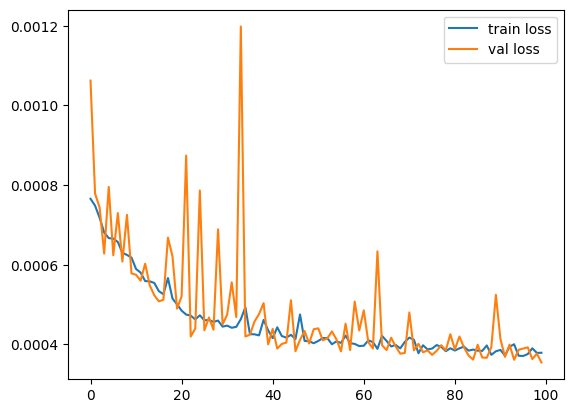

In [11]:
plt.plot(history['loss'],label='train loss')
plt.plot(history['val_loss'],label='val loss')
plt.legend()

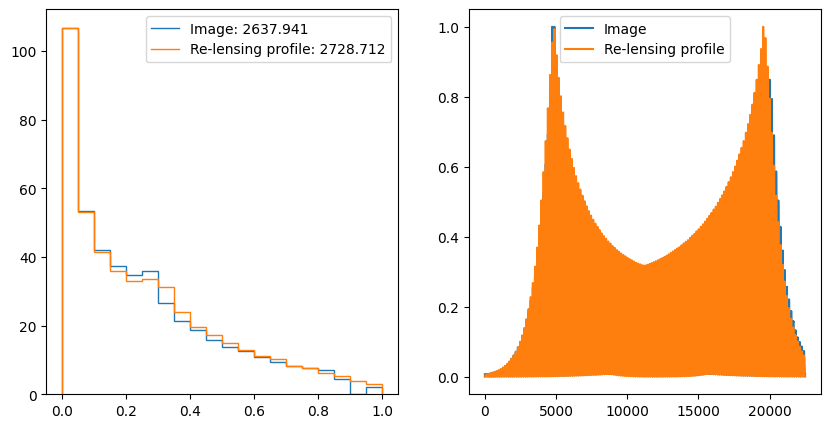

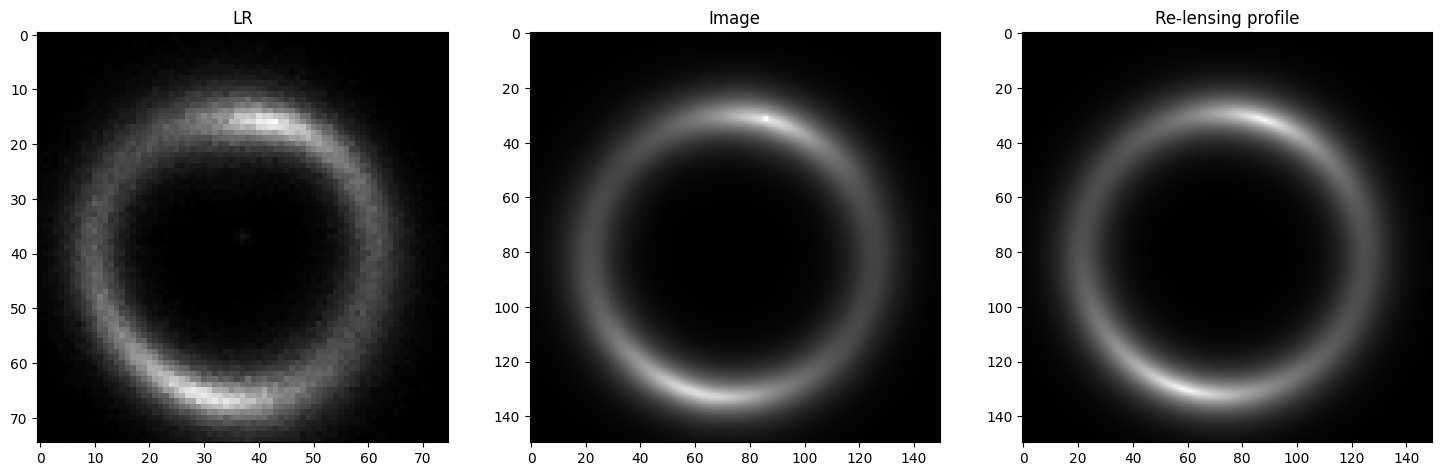

In [19]:
show_random_image(give_random_image(val_dataset, i_model, len(val_dataset)))

In [13]:
history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['relens'][0].save('relens.gif',save_all=True, append_images = history['relens'][1:], optimize=False, duration=100, loop=0)